In [1]:
!git clone https://github.com/11kartheek/ERA-v2.git

Cloning into 'ERA-v2'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 99 (delta 44), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (99/99), 169.19 KiB | 946.00 KiB/s, done.


In [2]:
%cd ERA-v2/s10

/kaggle/working/ERA-v2/s10


In [3]:
%ls

README.md  kartheekB_S10.ipynb  models.py  utils.py


In [4]:
!pip install torchsummary

In [5]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy
from models import Net
from utils import train_transforms,test_transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


# Dataset and Creating Train/Test Split

In [6]:
train = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:04<00:00, 34609822.05it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=False) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = F.cross_entropy(y_pred, target)
    train_losses.append(loss)
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [42]:
from torch.optim.lr_scheduler import StepLR
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model =  Net().to(device)
optimizer = optim.Adam(model.parameters(),lr = 0.001)
criterion = nn.CrossEntropyLoss()
from torch.optim.lr_scheduler import OneCycleLR

LRMIN = 0.001
LRMAX = 0.1
total_epochs = 24
max_at_epoch = 5

# One Cycle Policy scheduler
scheduler = OneCycleLR(optimizer, max_lr=LRMAX, epochs=total_epochs,
                       steps_per_epoch=len(train_loader), pct_start=max_at_epoch/total_epochs, anneal_strategy='cos',
                       div_factor=LRMAX/LRMIN)

EPOCHS = 24
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, criterion)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.2170302867889404 Batch_id=97 Accuracy=41.89: 100%|██████████| 98/98 [00:13<00:00,  7.11it/s]



Test set: Average loss: 1.3878, Accuracy: 4970/10000 (49.70%)

EPOCH: 1


Loss=0.9706799387931824 Batch_id=97 Accuracy=60.95: 100%|██████████| 98/98 [00:14<00:00,  6.91it/s]



Test set: Average loss: 0.9783, Accuracy: 6528/10000 (65.28%)

EPOCH: 2


Loss=0.7523077726364136 Batch_id=97 Accuracy=70.88: 100%|██████████| 98/98 [00:13<00:00,  7.11it/s]



Test set: Average loss: 0.7067, Accuracy: 7477/10000 (74.77%)

EPOCH: 3


Loss=0.6218823194503784 Batch_id=97 Accuracy=77.06: 100%|██████████| 98/98 [00:14<00:00,  6.88it/s]



Test set: Average loss: 0.6965, Accuracy: 7623/10000 (76.23%)

EPOCH: 4


Loss=0.5095558166503906 Batch_id=97 Accuracy=80.67: 100%|██████████| 98/98 [00:13<00:00,  7.04it/s]



Test set: Average loss: 0.5601, Accuracy: 8090/10000 (80.90%)

EPOCH: 5


Loss=0.4562423825263977 Batch_id=97 Accuracy=83.02: 100%|██████████| 98/98 [00:14<00:00,  6.90it/s] 



Test set: Average loss: 0.5305, Accuracy: 8218/10000 (82.18%)

EPOCH: 6


Loss=0.358212411403656 Batch_id=97 Accuracy=84.61: 100%|██████████| 98/98 [00:14<00:00,  6.99it/s]  



Test set: Average loss: 0.4939, Accuracy: 8291/10000 (82.91%)

EPOCH: 7


Loss=0.4051832854747772 Batch_id=97 Accuracy=86.33: 100%|██████████| 98/98 [00:14<00:00,  6.89it/s] 



Test set: Average loss: 0.4280, Accuracy: 8510/10000 (85.10%)

EPOCH: 8


Loss=0.374711275100708 Batch_id=97 Accuracy=87.30: 100%|██████████| 98/98 [00:14<00:00,  6.96it/s]  



Test set: Average loss: 0.4007, Accuracy: 8689/10000 (86.89%)

EPOCH: 9


Loss=0.36955684423446655 Batch_id=97 Accuracy=88.31: 100%|██████████| 98/98 [00:14<00:00,  6.96it/s]



Test set: Average loss: 0.3783, Accuracy: 8762/10000 (87.62%)

EPOCH: 10


Loss=0.27939265966415405 Batch_id=97 Accuracy=89.30: 100%|██████████| 98/98 [00:14<00:00,  6.94it/s]



Test set: Average loss: 0.4185, Accuracy: 8670/10000 (86.70%)

EPOCH: 11


Loss=0.27245885133743286 Batch_id=97 Accuracy=90.23: 100%|██████████| 98/98 [00:14<00:00,  6.87it/s]



Test set: Average loss: 0.3941, Accuracy: 8705/10000 (87.05%)

EPOCH: 12


Loss=0.4144383370876312 Batch_id=97 Accuracy=91.17: 100%|██████████| 98/98 [00:13<00:00,  7.07it/s] 



Test set: Average loss: 0.4309, Accuracy: 8677/10000 (86.77%)

EPOCH: 13


Loss=0.24688482284545898 Batch_id=97 Accuracy=91.65: 100%|██████████| 98/98 [00:14<00:00,  6.93it/s]



Test set: Average loss: 0.4137, Accuracy: 8638/10000 (86.38%)

EPOCH: 14


Loss=0.24329207837581635 Batch_id=97 Accuracy=91.93: 100%|██████████| 98/98 [00:13<00:00,  7.12it/s]



Test set: Average loss: 0.3696, Accuracy: 8806/10000 (88.06%)

EPOCH: 15


Loss=0.1913900077342987 Batch_id=97 Accuracy=92.63: 100%|██████████| 98/98 [00:14<00:00,  6.99it/s] 



Test set: Average loss: 0.3394, Accuracy: 8918/10000 (89.18%)

EPOCH: 16


Loss=0.22472193837165833 Batch_id=97 Accuracy=92.83: 100%|██████████| 98/98 [00:13<00:00,  7.10it/s]



Test set: Average loss: 0.3956, Accuracy: 8846/10000 (88.46%)

EPOCH: 17


Loss=0.18543608486652374 Batch_id=97 Accuracy=93.15: 100%|██████████| 98/98 [00:14<00:00,  6.87it/s]



Test set: Average loss: 0.3753, Accuracy: 8806/10000 (88.06%)

EPOCH: 18


Loss=0.21442468464374542 Batch_id=97 Accuracy=93.43: 100%|██████████| 98/98 [00:14<00:00,  7.00it/s]



Test set: Average loss: 0.3544, Accuracy: 8886/10000 (88.86%)

EPOCH: 19


Loss=0.22520433366298676 Batch_id=97 Accuracy=93.84: 100%|██████████| 98/98 [00:14<00:00,  6.96it/s]



Test set: Average loss: 0.4014, Accuracy: 8780/10000 (87.80%)

EPOCH: 20


Loss=0.2400979995727539 Batch_id=97 Accuracy=93.99: 100%|██████████| 98/98 [00:13<00:00,  7.09it/s] 



Test set: Average loss: 0.3598, Accuracy: 8868/10000 (88.68%)

EPOCH: 21


Loss=0.21768668293952942 Batch_id=97 Accuracy=94.04: 100%|██████████| 98/98 [00:14<00:00,  6.78it/s]



Test set: Average loss: 0.3941, Accuracy: 8850/10000 (88.50%)

EPOCH: 22


Loss=0.1829265058040619 Batch_id=97 Accuracy=94.64: 100%|██████████| 98/98 [00:13<00:00,  7.09it/s] 



Test set: Average loss: 0.4002, Accuracy: 8853/10000 (88.53%)

EPOCH: 23


Loss=0.1405666619539261 Batch_id=97 Accuracy=94.52: 100%|██████████| 98/98 [00:14<00:00,  6.85it/s] 



Test set: Average loss: 0.4019, Accuracy: 8904/10000 (89.04%)



In [11]:
!pip install torch-lr-finder

  0%|          | 0/125 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.42E-07


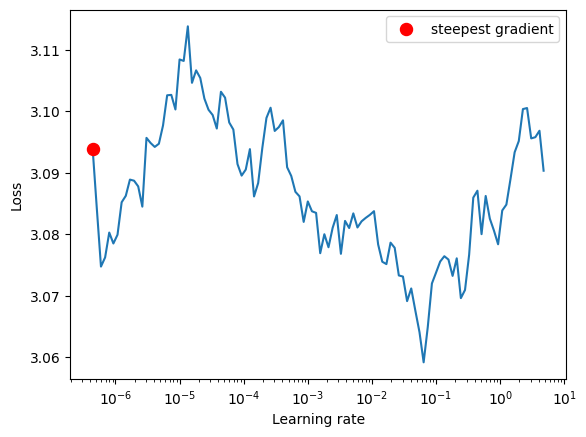

In [41]:
from torch_lr_finder import LRFinder
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.0000001)
model =  Net().to(device)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=125)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()